# Reddit Comment Generator

We will first see if we can generate highly upvoted reddit comments using a language model. Next it would be cool to score a given reddit comment, predicting its upvotes just from the text.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os

import requests
import numpy as np
import pandas as pd
import dill as pickle


user_list = !whoami
username = user_list[0]
PATH = f'/home/{username}/data/reddit/'

### Fetch training data

First let's download all the reddit comments from 2005 - 2010.

The latest we can go is 11/2017.

In [2]:
os.makedirs(f'{PATH}/raw', exist_ok=True)
os.makedirs(f'{PATH}/models', exist_ok=True)
os.makedirs(f'{PATH}/tokens', exist_ok=True)
os.makedirs(f'{PATH}/csv', exist_ok=True)

In [3]:
# Generate filenames for downloads
year, end_year = 2005, 2010
month, end_month = 12, 2

files = []
while year < end_year or (year == end_year and month <= end_month):
    files.append(f'RC_{year}-{month:02}')
    # Increment through dates
    month += 1
    if month % 13 == 0:
        month = 1
        year += 1

In [4]:
# Idempotently download files from pushshift.io
BASE_URL = 'http://files.pushshift.io/reddit/comments/'
for filename in files:
    target_file = f'{PATH}raw/{filename}.bz2'
    if os.path.exists(target_file):
        print(f'Found {target_file}', end=', ')
        continue
    
    alt_name = f'{PATH}raw/{filename}'
    if os.path.exists(alt_name):
        print(f'Found {filename}', end=', ')
        continue
        
    print(f'\nDownloading {filename}...', end=' ')
    response = requests.get(f'{BASE_URL}{filename}.bz2', stream=True)
    response.raise_for_status()

    with open(target_file, 'wb') as f:
        for block in response.iter_content(1024):
            f.write(block)
    
    print('done')

Found RC_2005-12, Found RC_2006-01, Found RC_2006-02, Found RC_2006-03, Found RC_2006-04, Found RC_2006-05, Found RC_2006-06, Found RC_2006-07, Found RC_2006-08, Found RC_2006-09, Found RC_2006-10, Found RC_2006-11, Found RC_2006-12, Found RC_2007-01, Found RC_2007-02, Found RC_2007-03, Found RC_2007-04, Found RC_2007-05, Found RC_2007-06, Found RC_2007-07, Found RC_2007-08, Found RC_2007-09, Found RC_2007-10, Found RC_2007-11, Found RC_2007-12, Found RC_2008-01, Found RC_2008-02, Found RC_2008-03, Found RC_2008-04, Found RC_2008-05, Found RC_2008-06, Found RC_2008-07, Found RC_2008-08, Found RC_2008-09, Found RC_2008-10, Found RC_2008-11, Found RC_2008-12, Found RC_2009-01, Found RC_2009-02, Found RC_2009-03, Found RC_2009-04, Found RC_2009-05, Found RC_2009-06, Found RC_2009-07, Found RC_2009-08, Found RC_2009-09, Found RC_2009-10, Found RC_2009-11, Found RC_2009-12, Found RC_2010-01, Found RC_2010-02, 

In [5]:
# Extract bzip2 archives into plain text - this is ~34 million comments
!ls {PATH}raw/*.bz2 | xargs -I % sh -c "bzip2 -d %"

ls: cannot access '/home/matt/data/reddit/raw/*.bz2': No such file or directory


### Read training data into memory

We're going to read all our training data into a dataframe.


In [6]:
%%time
import csv
import json

MAX_COMMENTS = 1e7 # ~12GB memory usage
CSV_PATH = f'{PATH}csv/{MAX_COMMENTS}.csv'

if not os.path.exists(CSV_PATH):
    with open(CSV_PATH, 'w') as csvfile:
        columns = ['id', 'body']
        writer = csv.DictWriter(csvfile, fieldnames=columns)
        writer.writeheader()
        for file in files:
            with open(f'{PATH}raw/{file}') as f:
                print(f'reading {file}', end=', ')
                for line in f.readlines():
                    line_json = json.loads(line)
                    if len(line_json['body']) > 30:
                        writer.writerow({
                            'id': line_json['id'],
                            'body': line_json['body'],
                        })
                        
                if len(ids) > MAX_COMMENTS:
                    break
    

CPU times: user 20 µs, sys: 10 µs, total: 30 µs
Wall time: 62 µs


In [120]:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 10388732 entries, c13 to c098njl
Data columns (total 1 columns):
body    object
dtypes: object(1)
memory usage: 158.5+ MB
None


,body
id,
c13,A look at Vietnam and Mexico exposes the myth ...
c14,"The site states ""What can I use it for? Meetin..."
c15,Jython related topics by Frank Wierzbicki
c17,Saft is by far the best extension you could ta...
c19,How to take panoramic shots simply


In [8]:
train_percent = 0.8
valid_idx = int(len(df) * 0.8)
train_df = df[:valid_idx]
valid_df = df[valid_idx:]

### TODO

- dump a pickle of the model for the vocab
- start training model
- test model
- try with more files
- once language generation works - try training an upvote predictor with a small number of comments

In [9]:
import spacy
from fastai.nlp import LanguageModelData
from torchtext import vocab, data
from torchtext.datasets import language_modeling

In [10]:
import torch
print(torch.cuda.is_available())
print(torch.backends.cudnn.enabled)

True
True


In [11]:
TEXT = data.Field(lower=True, tokenize="spacy")

In [60]:
BATCH_SIZE = 48
BACKPROP_THRU_TIME = 70
MIN_WORD_FREQ = 10

In [61]:
import hashlib

def md5(s):
    return hashlib.md5(s.encode('utf-8')).hexdigest()

In [62]:
# Tokenizing is really slow, so cache the tokens if the text
# is the same.
from torchtext.data import Dataset, Example

def get_tokens(df, text_field, col_name):
    text = df[col_name].str.cat(sep=' <eos> ')
    file_path = f'{PATH}/tokens/{md5(text)}.pkl'
    if os.path.exists(file_path):
        with open(file_path, 'rb') as f:
            tokens = pickle.load(f)
    else:
        tokens = text_field.preprocess(text)
        tokens.append('<eos>')
        with open(file_path, 'wb') as f:
            pickle.dump(tokens, f)
    
    return tokens
        
def get_dataset(df, text_field, col_name):
    tokens = get_tokens(df, text_field, col_name)
    fields = [('text', text_field)]
    examples = [Example.fromlist([tokens], fields)]
    return Dataset(examples, fields)

In [63]:
%%time
from fastai.nlp import ConcatTextDatasetFromDataFrames
trn_ds = get_dataset(train_df, TEXT, 'body')
val_ds = get_dataset(valid_df, TEXT, 'body')
test_ds = None

CPU times: user 1.67 s, sys: 144 ms, total: 1.81 s
Wall time: 1.81 s


In [64]:
%%time
model_data = LanguageModelData(
    PATH,
    TEXT,
    trn_ds,
    val_ds,
    test_ds,
    BATCH_SIZE,
    BACKPROP_THRU_TIME,
    min_freq=MIN_WORD_FREQ,
)

CPU times: user 944 ms, sys: 47.9 ms, total: 992 ms
Wall time: 988 ms


In [112]:
VOCAB_NAME = 'TEXT-2'
with open(f'{PATH}models/{VOCAB_NAME}.pkl','wb') as f:
    pickle.dump(TEXT, f)

In [66]:
print('Num batches: ', len(model_data.trn_dl))
print('Num unique tokens in vocab: ', model_data.nt)
print('Num sentences in train: ', len(model_data.trn_ds[0].text))

Num batches:  2604
Num unique tokens in vocab:  16390
Num sentences in train:  5837403


In [67]:
EMBEDDING_SIZE = 200
NUM_LAYER_WEIGHTS = 1000
NUM_LAYERS = 3

In [68]:
# Reduce gradient descent momentum parameter, because
# we were told to and who's going to throw away free advice?
from functools import partial
import torch.optim as optim
optimization_func = partial(optim.Adam, betas=(0.7, 0.99))

In [69]:
from fastai.lm_rnn import seq2seq_reg
# Dropout parameters may need turning
learner = model_data.get_model(
    optimization_func, 
    EMBEDDING_SIZE,
    NUM_LAYER_WEIGHTS,
    NUM_LAYERS,
    dropouti=0.05,
    dropout=0.05,
    wdrop=0.1,
    dropoute=0.02,
    dropouth=0.05
)
learner.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learner.clip = 0.3

In [70]:
import warnings
warnings.filterwarnings("ignore")
learner.lr_find()

 82%|████████▏ | 2131/2604 [01:34<00:21, 22.15it/s, loss=20.2]

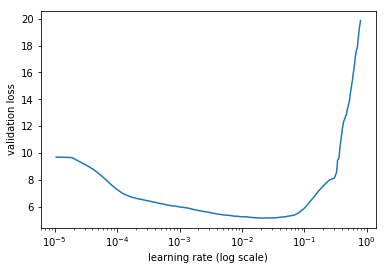

In [71]:
learner.sched.plot()

In [72]:
learning_rate = 0.01
weight_decay=1e-6

In [73]:
learner.fit(
    learning_rate,
    n_cycle=3,
)

epoch      trn_loss   val_loss                                
    0      6.461528   6.435034  
    1      5.521482   5.4615                                  
    2      5.348883   5.254914                                


[5.254913672711778]

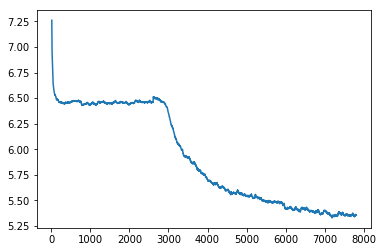

In [74]:
learner.sched.plot_loss()

In [75]:
learner.fit(
    learning_rate,
    n_cycle=3,
    wds=weight_decay,
    cycle_len=1,
    cycle_mult=2,
)

epoch      trn_loss   val_loss                                
    0      4.96017    4.859553  
    1      4.665619   4.646817                                
    2      4.549032   4.517701                                
    3      4.578193   4.579333                                
    4      4.476296   4.489767                                
    5      4.377718   4.405314                                
    6      4.333215   4.37327                                 


[4.373270442780203]

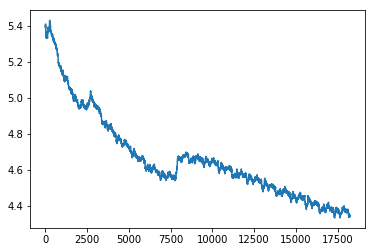

In [76]:
learner.sched.plot_loss()

In [104]:
learner.fit(
    learning_rate,
    n_cycle=3,
    wds=weight_decay,
    cycle_len=1,
    cycle_mult=2,
)

epoch      trn_loss   val_loss                                
    0      4.458031   4.394895  
    1      4.471405   4.44545                                 
    2      4.367187   4.355366                                
    3      4.462434   4.484357                                
    4      4.388247   4.413536                                
    5      4.309535   4.341952                                
    6      4.263284   4.31459                                 


[4.314590146458504]

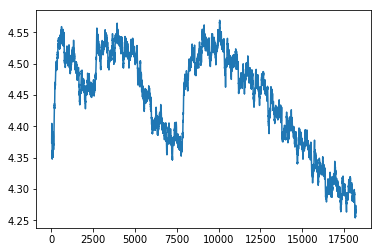

In [105]:
learner.sched.plot_loss()

In [106]:
ENCODER_NAME = 'reddit-encoder-2'
# reddit-encoder-1
#     22 it/s
#     validation loss of ~4.4
#     trained for 3x3 cycles with final loss 5.3 / 4.4 / 4.3
#     max_comments = 1e5
#     BATCH_SIZE = 32
#     BACKPROP_THRU_TIME = 70
#     MIN_WORD_FREQ = 10
#     EMBEDDING_SIZE = 200
#     NUM_LAYER_WEIGHTS = 500
#     NUM_LAYERS = 3
#     learning_rate = 0.01
#     weight_decay = 1e-6
#     dropouti = 0.05
#     dropout = 0.05
#     wdrop = 0.1
#     dropoute = 0.02
#     dropouth = 0.05
#     learner.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
#     learner.clip = 0.3
# reddit-encoder-2
#     validation loss of ?
#     trained for ? cycles
#     max_comments = 1e7
#     BATCH_SIZE = 48
#     BACKPROP_THRU_TIME = 70
#     MIN_WORD_FREQ = 10
#     EMBEDDING_SIZE = 200
#     NUM_LAYER_WEIGHTS = 1000
#     NUM_LAYERS = 3
#     learning_rate = 0.01
#     weight_decay = 1e-6
#     dropouti = 0.05
#     dropout = 0.05
#     wdrop = 0.1
#     dropoute = 0.02
#     dropouth = 0.05
#     learner.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
#     learner.clip = 0.3

In [107]:
learner.save_encoder(ENCODER_NAME)

In [108]:
learner.load_encoder(ENCODER_NAME)

In [113]:
with open(f'{PATH}models/{VOCAB_NAME}.pkl','rb') as f:
    TEXT = pickle.load(f)

In [114]:
# Subclass of torch.nn.Sequential
model = learner.model
model.eval() # Disable dropout
model.reset() # Reset hidden state
model[0].bs = 1 # Set batch size to 1

In [115]:
seed_text = (
    "what I really think is that we should look further into this. "
    "who can really say what he was"
)
seed_text_processed = [TEXT.preprocess(seed_text)]
seed_ints = TEXT.numericalize(seed_text_processed)

In [116]:
results, *_ = model(seed_ints.cuda())

In [117]:
import random

def get_word(i):
    return TEXT.vocab.itos[i]

PUNCTUATION = (',', '.', '!', '?')
TOP_K = 5

text = seed_text
for _ in range(100):
    top_results = list(results[-1].topk(TOP_K)[1])
    random.shuffle(top_results)
    next_int = top_results[1] if top_results[0] == 0 else top_results[0]    
    next_word = get_word(next_int)
    input_tensor = torch.tensor([[next_int]]).cuda()
    results, *_ = model(input_tensor)
    if next_word in PUNCTUATION:
        text += next_word
    elif next_word in ('<', 'eos', '>'):
        pass
    elif text[-1] in PUNCTUATION:
        text += ' ' + next_word.title()
    else:
        text += ' ' + next_word    

In [118]:
import re
text = re.compile(r'\s+').sub(r' ', text)
text = (
    text
    .replace('\r', ' ')
    .replace('\n', ' ')
    .replace(' ', ' ')
)
print(text)

what I really think is that we should look further into this. who can really say what he was thinking about and he would be able to be more likely in this kind. he 's saying it would be nice. it seems to be that we can all get to be in the world where people can use it for a while, So it will not be a bad idea if they do. i think it was the best case, And the only problem is that the author has a lot of people. but i think it should have done more. 
